# SPTAN1
The spectrins, including nonerythrocytic alpha-spectrin-1 (SPTAN1), are a family of widely-distributed filamentous cytoskeletal proteins which have a highly conserved 106-amino acid repeat structure [OMIM:182810](https://omim.org/entry/182810).

Variants in SPTAN1 are associated with four diseases:

- Developmental and epileptic encephalopathy 5: [OMIM:613477](https://omim.org/entry/613477)
- Developmental delay with or without epilepsy: [OMIM:620540](https://omim.org/entry/620540)
- Neuronopathy, distal hereditary motor, autosomal dominant 11: [OMIM:620528](https://omim.org/entry/620528)
- Spastic paraplegia 91, autosomal dominant, with or without cerebellar ataxia: [OMIM:620538](https://omim.org/entry/620538)


[Van de Vondel  et al (2022)](https://pubmed.ncbi.nlm.nih.gov/35150594/) state:

> Although age of onset, disease severity and some phenotypical traits can differ, correlations can be made between SPTAN1 variants and the predominantly associated phenotype, such as the p.Lys2083del mutation in the cerebellar atactic phenotype and the p.ç mutation in the HSP phenotype. C-terminal in-frame insertions, deletions and duplications are highly linked to severe, early-onset epileptic encephalopathies and West syndrome. These variants are located within the spectrin dimerization domain, and one has been shown to cause spectrin aggregates in patient-derived iPSCs. In contrast, nonsense mutations are seen more frequently in patients with mild HMN, where a haploinsuffiency mechanism is proposed due to nonsense-mediated decay.

[Morsey et al. (2022)](https://pubmed.ncbi.nlm.nih.gov/36331550/) suggest that

>  truncating variants are responsible for a mild DD with or without epilepsy.

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using genophenocorr version {gpsea.__version__}")

Loaded HPO v2024-12-12
Using genophenocorr version 0.9.2


# SPTAN1
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for SPTAN1.

In [2]:
gene_symbol = 'SPTAN1'
mane_tx_id = 'NM_001130438.3'
mane_protein_id = "NP_001123910.1" # spectrin alpha chain, non-erythrocytic 1 isoform

In [4]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets, load_phenopacket_folder

from ppktstore.registry import configure_phenopacket_registry
phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.23") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)
"""
cohort, validation = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
"""
sptan_dir = "../../../phenopacket-store/notebooks/SPTAN1/phenopackets/"
cohort, validation = load_phenopacket_folder(
    pp_directory=sptan_dir,
    cohort_creator=cohort_creator
)
validation.summarize()

Individuals Processed: 85 individuals [00:05, 16.90 individuals/s]
Validated under permissive policy
No errors or warnings were found


In [5]:
from gpsea.view import CohortViewer
cv = CohortViewer(hpo=hpo)
cv.process(cohort=cohort, transcript_id=mane_tx_id)

n,HPO Term
27,Intellectual disability
22,Lower limb muscle weakness
21,Spastic paraplegia
20,Ataxia
20,Global developmental delay
19,Abnormal pyramidal sign
19,Microcephaly
16,Hypotonia
16,Hypsarrhythmia
16,Cerebellar atrophy


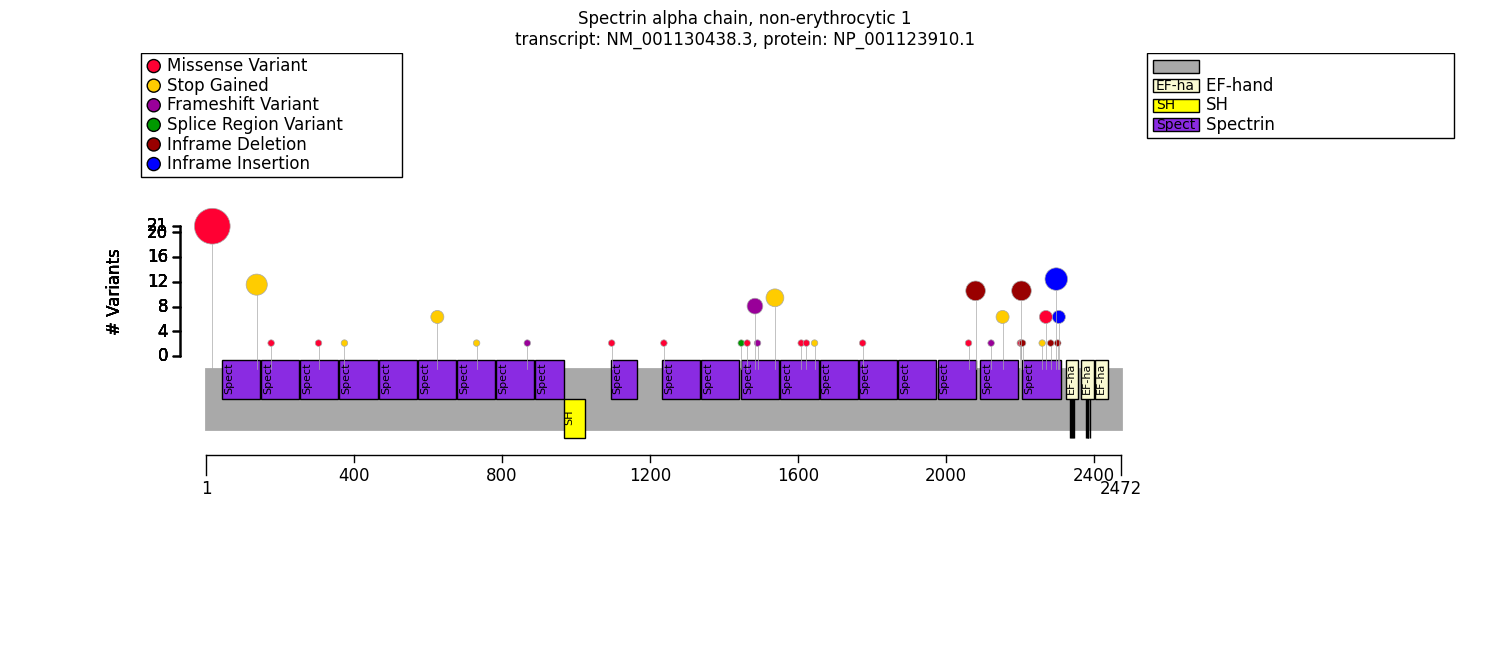

In [6]:
from gpsea.model.genome import GRCh38
from gpsea.model import ProteinMetadata
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

sptan1_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
sptan1_fig.tight_layout()

In [7]:
from gpsea.view import ProteinVariantViewer
viewer = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
viewer.process(cohort)

Count,Name,Type,Coordinates,Variants
6,Spectrin 1,Repeat,46 - 146,p.Arg139Ter
1,Spectrin 2,Repeat,151 - 251,p.Gly178Asp
1,Spectrin 3,Repeat,257 - 358,p.Ala306Val
1,Spectrin 4,Repeat,362 - 465,p.Trp376Ter
0,Spectrin 5,Repeat,469 - 570,
2,Spectrin 6,Repeat,575 - 676,p.Arg627Ter
1,Spectrin 7,Repeat,680 - 781,p.Arg733Ter
1,Spectrin 8,Repeat,786 - 888,p.Lys871SerfsTer5
0,Spectrin 9,Repeat,892 - 969,
0,SH3,Domain,968 - 1026,


In [8]:
from gpsea.view import CohortVariantViewer

viewer = CohortVariantViewer(tx_id=mane_tx_id)
viewer.process(cohort)

Count,Variant key,HGVS,Overlapping Exons,Effects
21,9_128566795_128566795_C_T,c.55C>T (p.Arg19Trp),2,missense
6,9_128574726_128574726_C_T,c.415C>T (p.Arg139Ter),4,stop gained
6,9_128632260_128632260_G_GGGACCAGCT,c.6908_6916dup (p.Asp2303_Leu2305dup),53,inframe insertion
5,9_128625939_128625942_CAAG_C,c.6247_6249del (p.Lys2083del),48,inframe deletion
4,9_128627422_128627425_CAGG_C,c.6619_6621del (p.Glu2207del),50,inframe deletion
4,SO:1000029_HGNC:11273_SPTAN1,SV involving SPTAN1 (p.?),,chromosomal deletion
4,9_128609141_128609141_C_T,c.4615C>T (p.Gln1539Ter),36,stop gained
3,9_128608237_128608238_CA_C,c.4458del (p.Lys1486AsnfsTer51),34,frameshift
2,9_128583149_128583149_C_T,c.1879C>T (p.Arg627Ter),15,stop gained
2,9_128626571_128626571_C_T,c.6460C>T (p.Gln2154Ter),49,stop gained


## Genotype-Phenotype Correlation (GPC) Analysis

In [9]:
from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
from gpsea.analysis.pcats import configure_hpo_term_analysis

analysis = configure_hpo_term_analysis(hpo)
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [10]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate import variant_effect
from gpsea.analysis.clf import monoallelic_classifier
from gpsea.view import MtcStatsViewer

missense = variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)

missense_clf = monoallelic_classifier(
    a_predicate=missense, 
    b_predicate=~missense, 
    a_label="missense",
    b_label= "other"
)

missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)

viewer = MtcStatsViewer()
viewer.process(missense_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,34
HMF08,Skipping general term,44
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,172


In [11]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group                                   missense  ...              
                                                  Count  ...      p values
Lower limb spasticity [HP:0002061]                21/22  ...  2.370731e-08
Spastic paraplegia [HP:0001258]                   21/25  ...  4.700349e-08
Appendicular spasticity [HP:0034353]              21/22  ...  8.724291e-07
Motor axonal neuropathy [HP:0007002]               0/19  ...  2.181073e-06
Spasticity [HP:0001257]                           22/23  ...  5.222578e-06
Epileptic spasm [HP:0011097]                       2/22  ...  2.925201e-05
Seizure [HP:0001250]                              13/33  ...  2.481060e-04
Intellectual disability [HP:0001249]               9/32  ...  3.428093e-04
Peripheral axonal neuropathy [HP:0003477]          4/23  ...  6.689983e-04
Distal lower limb muscle weakness [HP:0009053]     9/19  ...  1.470355e-03
Motor seizure [HP:0020219]                         7/27  ...  1.704741e-03
Infantile spasms [HP:0012469]                      2/29  ...  2.364326e-03
Microcephaly [HP:0000252]                          4/34  ...  2.446338e-03
Lower limb muscle weakness [HP:0007340]           15/16  ...  1.514693e-02
Hypotonia [HP:0001252]                              3/9  ...  4.604915e-01
Ataxia [HP:0001251]                               11/30  ...  5.718296e-01
Abnormal muscle tone [HP:0003808]                 24/24  ...  1.000000e+00
Neurodevelopmental delay [HP:0012758]               5/5  ...  1.000000e+00
Neurodevelopmental abnormality [HP:0012759]       11/11  ...  1.000000e+00
Muscle weakness [HP:0001324]                      17/17  ...  1.000000e+00

[20 rows x 6 columns]

In [15]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate import variant_effect, anyof

nonsense = variant_effect(VariantEffect.STOP_GAINED, tx_id=mane_tx_id)
frameshift = variant_effect(VariantEffect.FRAMESHIFT_VARIANT, tx_id=mane_tx_id)
truncating = anyof((nonsense, frameshift))

truncating_clf = monoallelic_classifier(
    a_predicate=truncating, 
    b_predicate=~truncating,  
    a_label="truncating",
    b_label= "other"
)

truncating_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=truncating_clf,
    pheno_clfs=pheno_clfs,
)

summarize_hpo_analysis(hpo=hpo, result=truncating_result)

Allele group                                truncating  ...              
                                                 Count  ...      p values
Motor axonal neuropathy [HP:0007002]             12/12  ...  1.198392e-09
Peripheral axonal neuropathy [HP:0003477]        12/12  ...  4.653782e-07
Spasticity [HP:0001257]                            0/8  ...  2.091875e-05
Appendicular spasticity [HP:0034353]               0/8  ...  4.253092e-05
Lower limb spasticity [HP:0002061]                 0/8  ...  7.088486e-05
Spastic paraplegia [HP:0001258]                    0/8  ...  1.318392e-03
Hypotonia [HP:0001252]                            1/11  ...  4.098859e-03
Ataxia [HP:0001251]                               2/10  ...  2.789268e-01
Intellectual disability [HP:0001249]              6/10  ...  5.026802e-01
Lower limb muscle weakness [HP:0007340]          14/22  ...  5.097883e-01
Seizure [HP:0001250]                               2/2  ...  5.147541e-01
Abnormal muscle tone [HP:0003808]                  1/1  ...  1.000000e+00
Neurodevelopmental delay [HP:0012758]              9/9  ...  1.000000e+00
Neurodevelopmental abnormality [HP:0012759]      10/10  ...  1.000000e+00
Muscle weakness [HP:0001324]                     15/15  ...  1.000000e+00

[15 rows x 6 columns]

In [16]:
from gpsea.analysis.predicate import variant_key

r19w = variant_key(key="9_128566795_128566795_C_T") # c.55C>T	p.Arg19Trp
r19w_clf = monoallelic_classifier(
    a_predicate=r19w,
    b_predicate=~r19w,
    a_label="Arg19Trp",
    b_label="Other"
)

r19w_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=r19w_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=r19w_result)

Allele group                                   Arg19Trp  ...              
                                                  Count  ...      p values
Spastic paraplegia [HP:0001258]                   21/21  ...  3.715691e-12
Lower limb spasticity [HP:0002061]                21/21  ...  1.077605e-09
Intellectual disability [HP:0001249]               0/21  ...  1.758345e-09
Seizure [HP:0001250]                               2/21  ...  2.357270e-09
Motor seizure [HP:0020219]                         0/19  ...  3.342060e-08
Appendicular spasticity [HP:0034353]              21/21  ...  4.543901e-08
Epileptic spasm [HP:0011097]                       0/19  ...  7.708573e-07
Spasticity [HP:0001257]                           21/21  ...  1.054857e-06
Motor axonal neuropathy [HP:0007002]               0/16  ...  6.256563e-05
Microcephaly [HP:0000252]                          0/21  ...  2.454105e-04
Distal lower limb muscle weakness [HP:0009053]     8/15  ...  1.893638e-03
Lower limb muscle weakness [HP:0007340]           14/14  ...  3.445016e-03
Peripheral axonal neuropathy [HP:0003477]          4/20  ...  9.530109e-03
Ataxia [HP:0001251]                                7/21  ...  5.601563e-01
Abnormal muscle tone [HP:0003808]                 21/21  ...  1.000000e+00
Muscle weakness [HP:0001324]                      16/16  ...  1.000000e+00

[16 rows x 6 columns]

According to [Van de Vondel  et al (2022)](https://pubmed.ncbi.nlm.nih.gov/35150594/), the p.Lys2083del mutation is associated with a cerebellar atactic phenotype. We show here that if one tests against all terms, there is a nominally significant result that does not survive multiple testing correction. We also show how to test specifically for the term Ataxia.

In [17]:
k2083del = variant_key(key="9_128625939_128625942_CAAG_C") # c.6247_6249del	p.Lys2083del	
k2083del_clf = monoallelic_classifier(
    a_predicate=k2083del,
    b_predicate=~k2083del,
    a_label="Lys2083del",
    b_label="Other"
)

k2083del_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=k2083del_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=k2083del_result)

Allele group                                Lys2083del  ...          
                                                 Count  ...  p values
Ataxia [HP:0001251]                                5/5  ...  0.007317
Spastic paraplegia [HP:0001258]                    0/4  ...  0.047842
Seizure [HP:0001250]                               1/5  ...  0.073232
Motor seizure [HP:0020219]                         0/4  ...  0.113966
Peripheral axonal neuropathy [HP:0003477]          0/4  ...  0.129786
Epileptic spasm [HP:0011097]                       0/4  ...  0.145785
Intellectual disability [HP:0001249]               4/5  ...  0.192715
Neurodevelopmental delay [HP:0012758]              1/1  ...  1.000000
Neurodevelopmental abnormality [HP:0012759]        4/4  ...  1.000000

[9 rows x 6 columns]

In [21]:
from gpsea.analysis.clf import sex_classifier
mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=mf_result)

Sex                 FEMALE           MALE                                     
                     Count Percent  Count Percent Corrected p values  p values
Ataxia [HP:0001251]  10/21     48%  10/29     34%           0.392718  0.392718

# Summary

In [22]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary

fet_results = (
    GPAnalysisResultSummary.from_multi( result=missense_result, ),
    GPAnalysisResultSummary.from_multi( result=truncating_result, ),
    GPAnalysisResultSummary.from_multi( result=r19w_result, ),
    GPAnalysisResultSummary.from_multi( result=k2083del_result, ),
    GPAnalysisResultSummary.from_multi( result=mf_result, ),
)

caption = """Several publications have identified genotype-phenotype correlations in SPTAN1 that are comparable to those
identified here \\cite{PMID_25631096,PMID_36331550,PMID_35150594}.
"""

report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=fet_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)

In [23]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

HPO Term,missense,other,p-val,adj. p-val
Spastic paraplegia [HP:0001258],21/25 (84%),0/16 (0%),4.70e-08,4.70e-07
Lower limb spasticity [HP:0002061],21/22 (95%),0/12 (0%),2.37e-08,4.70e-07
Appendicular spasticity [HP:0034353],21/22 (95%),2/14 (14%),8.72e-07,5.82e-06
Spasticity [HP:0001257],22/23 (96%),4/16 (25%),5.22e-06,2.09e-05
Motor axonal neuropathy [HP:0007002],0/19 (0%),12/16 (75%),2.18e-06,1.09e-05
Peripheral axonal neuropathy [HP:0003477],4/23 (17%),12/16 (75%),6.69e-04,0.001
Motor seizure [HP:0020219],7/27 (26%),13/17 (76%),0.002,0.003
Seizure [HP:0001250],13/33 (39%),24/28 (86%),2.48e-04,7.09e-04
Intellectual disability [HP:0001249],9/32 (28%),18/23 (78%),3.43e-04,8.57e-04
Lower limb muscle weakness [HP:0007340],15/16 (94%),16/28 (57%),0.015,0.022


In [24]:
summarizer.process_latex(report=report, protein_fig=sptan1_fig)

Figure saved to ../../supplement/img/SPTAN1_protein_diagram-draft.pdf
Output to ../../supplement/tex/SPTAN1_summary_draft.tex
